In [342]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels
from skimage import data, segmentation
from skimage import graph
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

from skimage.color import rgb2hsv, label2rgb
import matplotlib.pyplot as plt
from time import time
from skimage.measure import label

from dataclasses import dataclass
from typing import Tuple


IMG_SIZE = 350
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

In [343]:
from hr_dv2 import HighResDV2

net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [344]:
shift_dists = [i for i in range(1, 3)]
fwd_shift, inv_shift = tr.get_shift_transforms(shift_dists, 'Moore')

fwd_flip, inv_flip = tr.get_flip_transforms()
#fwd, inv = fwd_flip, inv_flip
fwd, inv = fwd_shift, inv_shift
#fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)
net.set_transforms(fwd, inv)

In [345]:
def get_dv2_features(net: HighResDV2, tensor: torch.Tensor, flatten: bool=True, sequential: bool=False) -> np.ndarray:
    # Given a HR-DV2 net with set transforms, get features. Either (c, h, w) or (h * w, c) depending on flatten.
    # Use sequential for high memory (large image and/or n_transforms) situations.
    if sequential:
        hr_tensor, _ = net.forward_sequential(tensor, attn='none')
    else:
        hr_tensor, _ = net.forward(tensor, attn='none')
    features: np.ndarray
    b, c, fh, fw = hr_tensor.shape
    features = tr.to_numpy(hr_tensor)
    out: np.ndarray = features
    if flatten:
        out = features.reshape((c, fh * fw)).T
    return out

def do_pca(features: np.ndarray, k: int=3, standardize: bool=True) -> np.ndarray:
    # k component dimensionality reduction of (n_samples, n_channels) features.
    if standardize:
        features = standardize_img(features)
    pca = PCA(n_components=k, svd_solver='randomized', n_oversamples=5, iterated_power=3)
    pca.fit(features)
    projection = pca.transform(features)
    return projection

# helper functions for region adjancency merging later
def _weight_mean_color(graph, src, dst, n):
        diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
        diff = np.linalg.norm(diff)
        return {'weight': diff}
    
def _merge_mean_color(graph, src, dst):
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                    graph.nodes[dst]['pixel count'])


@dataclass
class CRFParams():
    label_confidence: float=0.6
    sxy_g: Tuple[int, int] = (3, 3)
    sxy_b: Tuple[int, int] = (80, 80)
    s_rgb: Tuple[int, int, int] = (13, 13, 13)
    compat_g: float = 10
    compat_b: float = 10
    n_infer: int = 10

KERNEL = dcrf.FULL_KERNEL
default_crf_params = CRFParams()


def do_crf_from_labels(labels_arr: np.ndarray, img_arr: np.ndarray, n_classes: int, crf: CRFParams) -> np.ndarray:
    h, w, c = img_arr.shape
    unary = unary_from_labels(labels_arr, n_classes, crf.label_confidence, zero_unsure=False)
    d = dcrf.DenseCRF2D(w, h, n_classes)
    u = np.ascontiguousarray(unary)
    d.setUnaryEnergy(u)
    d.addPairwiseGaussian(sxy=crf.sxy_g, compat=crf.compat_g, kernel=KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseBilateral(sxy=crf.sxy_b, srgb=crf.s_rgb, rgbim=img_arr, compat=crf.compat_b, kernel=KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(crf.n_infer)
    crf_seg = np.argmax(Q, axis=0)
    crf_seg = crf_seg.reshape((h, w, 1))
    return crf_seg


In [346]:
@dataclass
class SLICParams():
    compactness: float = 30
    n_initial_segments: int = 400
    convert2lab: bool = True
    sigma: float = 1
    enforce_connectivity: bool = False

default_SLIC_params = SLICParams() 


def RAG(net: HighResDV2, img_arr: np.ndarray, img_tensor: torch.Tensor, thresholds: List[float], 
        slic_param: SLICParams, crf_params: CRFParams, verbose: bool=False) -> List[np.ndarray]:
    start = time()
    ih, iw, ic = img_arr.shape
    features = get_dv2_features(net, img_tensor, True)
    pca = do_pca(features, 3, True)
    # convert pca'd features to 'image'
    reshaped = rescale_pca(pca).reshape((ih, iw, 3))
    rescaled = (255 * reshaped).astype(np.uint8)

    initial_seg = segmentation.slic(rescaled, compactness=slic_param.compactness, 
                                             n_segments=slic_param.n_initial_segments, start_label=0, 
                                             convert2lab=slic_param.convert2lab, sigma=slic_param.sigma,
                                             enforce_connectivity=slic_param.enforce_connectivity)
    region_adjacency_graph = graph.rag_mean_color(rescaled, initial_seg)
    segmentations = []
    for t in thresholds:
        merged_segmentation = graph.merge_hierarchical(initial_seg, region_adjacency_graph, thresh=t, rag_copy=False,
                                                        in_place_merge=True, merge_func=_merge_mean_color, 
                                                        weight_func=_weight_mean_color)
        n_classes = np.amax(merged_segmentation) + 1
        refined_segmenatation = do_crf_from_labels(merged_segmentation, img_arr, n_classes, crf_params)
        segmentations.append(refined_segmenatation)
    end = time()
    if verbose:
        print(f"Finished in {end-start}s")
    return segmentations



In [347]:
def elbow(net: HighResDV2, img_arr: np.ndarray, img_tensor: torch.Tensor, 
          clusters: List[int], verbose: bool=False) -> Tuple[List[np.ndarray], np.ndarray]:
    start = time()
    ih, iw, ic = img_arr.shape
    net.set_transforms([], [])
    attn, _ = net.forward(img_tensor, attn='cls')
    attn = tr.to_numpy(attn)
    net.set_transforms(fwd, inv)
    hr_tensor, _ = net.forward(img_tensor, attn='none')
    features: np.ndarray
    b, c, fh, fw = hr_tensor.shape
    features = tr.to_numpy(hr_tensor)
    reshaped = features.reshape((c, fh * fw)).T

    normed = normalise_pca(reshaped)
    

    labels, scores = [], []
    for n in clusters:
        cluster = KMeans(n_clusters=n, n_init='auto', max_iter=300)
        label = cluster.fit_predict(normed)
        #refined_seg = do_crf_from_labels(label, img_arr, n, default_crf_params)
        refined_seg = label
        score = calinski_harabasz_score(normed, label)
        print(score)
        labels.append(refined_seg)
        scores.append(score)

    end = time()
    if verbose:
        print(f"Finished in {end-start}s")
    return labels, attn

In [348]:
transform = tr.get_input_transform(IMG_SIZE, IMG_SIZE)

In [349]:
thresholds = np.arange(25, 200, 25)
clusters = [40]

path = "data/v18.png"
_img = Image.open(path)
h, w = _img.height, _img.width
if 'v' not in path:
    t = transform
else:
    t = tr.closest_crop(h, w, 14, True)
tensor, img = tr.load_image(path, t)
img_arr = np.array(img)


tensor.to(torch.float16)
tensor = tensor.cuda()

#segs = RAG(net, img_arr, tensor, thresholds, default_SLIC_params, default_crf_params, True)
segs, attn = elbow(net, img_arr, tensor, clusters, True)
tensor = tensor.cpu()

FileNotFoundError: [Errno 2] No such file or directory: 'data/v18.jpg'

(2,)


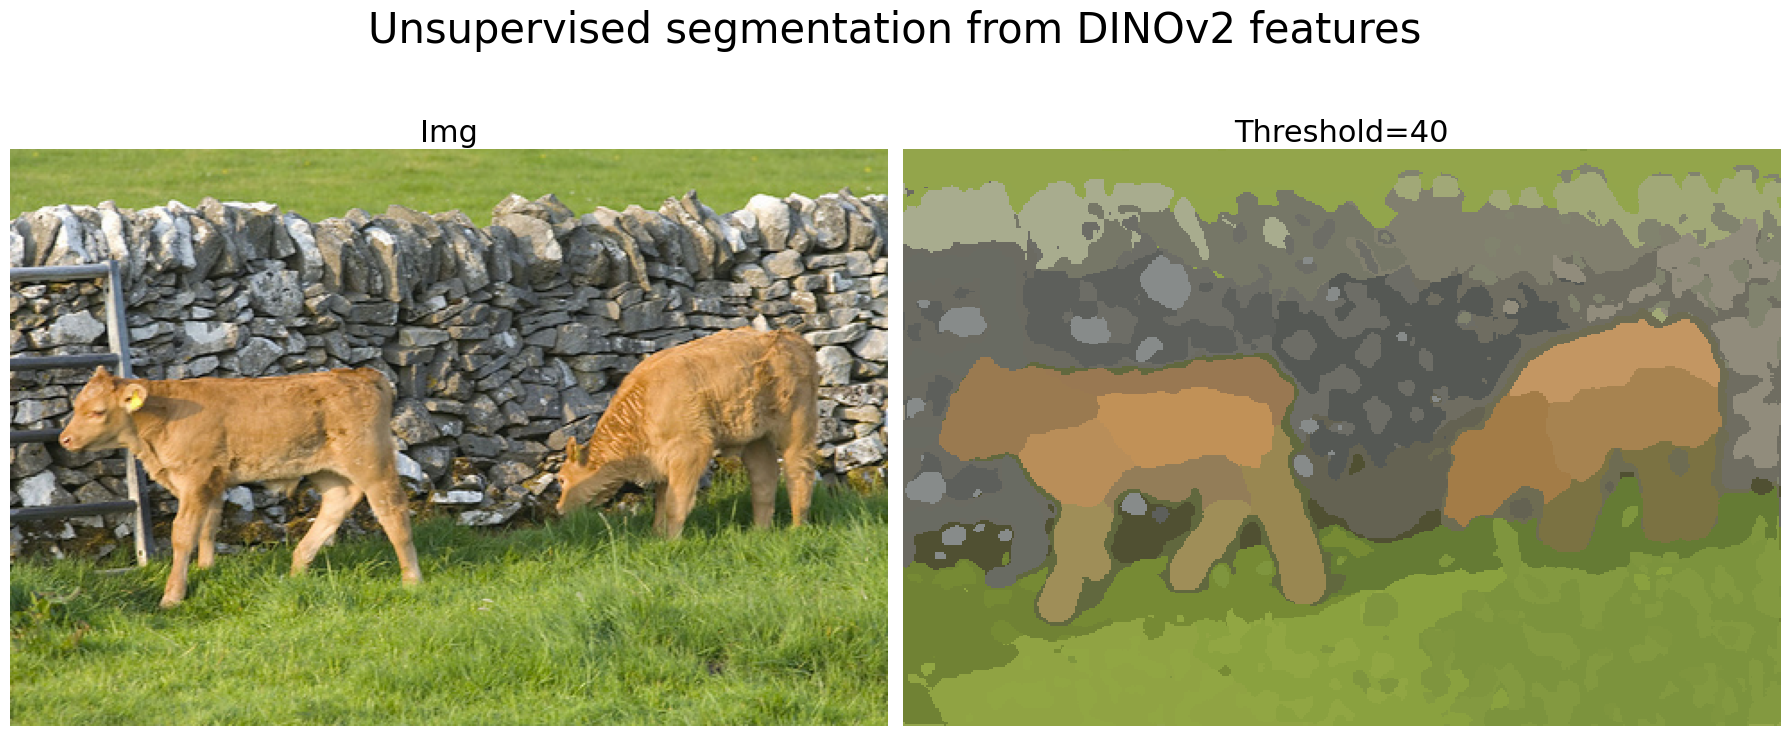

In [ ]:
N_COLS = len(clusters) + 1
N_ROWS = 1
fig, axs = plt.subplots(nrows=N_ROWS, ncols=N_COLS)
fig.set_size_inches(18, 8)
print(axs.shape)
ih, iw, c = img_arr.shape

plt.suptitle("Unsupervised segmentation from DINOv2 features", fontsize=30, y=1.0)

I = 0
for j, arr in enumerate([img_arr] + segs):
    ax = axs[j]
    
    title = "Img"
    if j > 0:
        arr = arr.reshape((ih, iw)) + 1
        title = f"Threshold={clusters[j - 1]}"
        arr = label2rgb(arr, img_arr, kind='avg')
        ax.imshow(arr, cmap='tab20', interpolation='nearest')
    else:
        ax.imshow(arr)
    ax.set_title(title, fontsize=22)
    ax.set_axis_off()
plt.tight_layout()

In [ ]:
sum_cls = np.sum(attn, axis=0)
labels2D = segs[0].reshape((ih, iw))
print(sum_cls.shape)

def get_attn_density(labels_arr: np.ndarray, attn: np.ndarray) -> Tuple[np.ndarray, List[float]]:
    densities = []
    attention_density_map = np.zeros_like(labels_arr).astype(np.float64)
    n_clusters = np.amax(labels_arr)
    for n in range(n_clusters):
        binary_mask = np.where(labels_arr == n, 1, 0)
        n_pix = np.sum(binary_mask)
        cluster_attn = np.sum(attn * binary_mask)
        cluster_attn_density = cluster_attn / n_pix
        densities.append(cluster_attn_density)
        attention_density_map += cluster_attn_density * binary_mask
    return attention_density_map, densities

density_map, densities = get_attn_density(labels2D, sum_cls)


(322, 490)


21.94350289475157 [ 7. 14.  7.  0.  2.  2.  2.  3.  1.  1.] [ 8.51026972 12.98801411 17.4657585  21.94350289 26.42124729 30.89899168
 35.37673607 39.85448047 44.33222486 48.80996925 53.28771364]


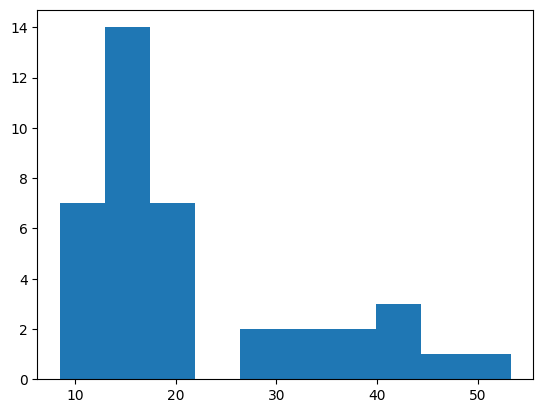

In [ ]:
n, bins, _ = plt.hist(densities, bins=10)
max_loc = int(np.argmax(n))
cutoff = bins[max_loc + 2] #max_loc + 2
print(cutoff, n, bins)

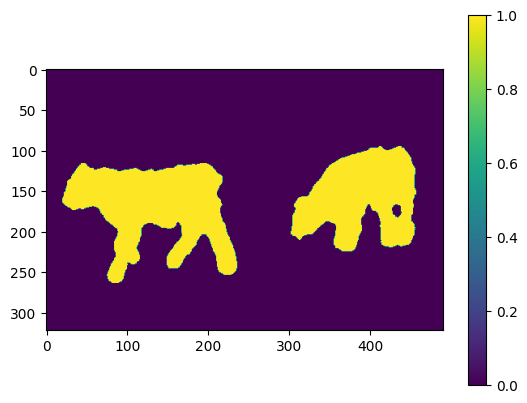

In [ ]:
fg_seg = (density_map > cutoff).astype(np.uint8)
plt.imshow(fg_seg)
plt.colorbar()

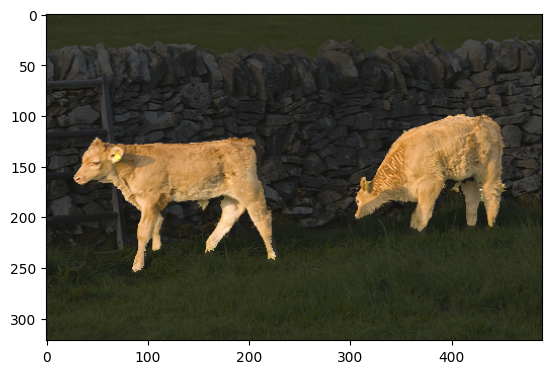

In [ ]:
refined = do_crf_from_labels(fg_seg, img_arr, 2, default_crf_params)

alpha_mask = np.where(refined == 1, [1, 1, 1, 1], [0.25, 0.25, 0.25, 0.95])
img = img.convert("RGBA")
masked = (img * alpha_mask).astype(np.uint8)
plt.imshow(masked )